Objective: Determine Weyl chamber regions spanned by x iterations of $\sqrt[n]{iSwap}$ circuit templates.\
a. Step through weyl coordinates -> Pass to NuOp -> Color point based on length of template required\
b. (Later) Vectorization ML Task

In [1]:
import numpy as np
import weylchamber
from nuop_script import TemplateCircuit
from scipy import optimize as opt
import pickle
import weylchamber
from custom_gates import *
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

In [2]:
import logging

logger = logging.getLogger()
#logger.setLevel(logging.INFO)
# use ERROR if you want to hide verbose print outs
logger.setLevel(logging.ERROR)

In [3]:
class TemplateOptimizer:
    def __init__(
        self,
        template,
        weyl_coordinates=(0,0,0),
        objective_function_name="square",
        template_iter_range=range(2, 4)
    ):
        """Args:
        template: TemplateCircuit object
        objective_function_name: "nuop|basic" or "weyl"
        unitary_sample_function: "Haar" or "Clifford for random sampling, "SWAP", "CNOT", "iSWAP" for single gates
        n_samples: the number of times to sample a gate and minimize template on
        template_iter_range: a range() object that whos values are passed to template.build()
        """
        self.template = template
        self.weyl_coordinates = weyl_coordinates
        self.obj_f_name = objective_function_name
        self.template_iter_range = template_iter_range

    def run(self):
        # run minimize on the remaining samples
        best_result, best_Xk, best_cycles = None, None, None

        obj = self._objective_function(self.obj_f_name)
        best_result, best_Xk, best_cycles = self.minimize(
            obj=obj, t_range=self.template_iter_range)
                
        return best_result, best_Xk, best_cycles

    def minimize(self, obj, t_range):
        # NOTE: potential for speedup?
        # you can calculate ahead of time the number of repetitions needed using traces??

        # callback used to save current loss after each iteration
        # def callbackF(xk):
        #     loss = obj(xk)
        #     temp_training_loss.append(loss)

        best_result = None
        best_Xk = None
        best_cycles = -1

        # each t creates fresh template with new repetition param
        for t in t_range:
            logging.info(f"Starting cycle length {t}")

            self.template.build(n_repetitions=t)

            starting_attempts = 5
            for _ in range(starting_attempts):
                result = opt.minimize(
                    fun=obj,
                    x0=self.template.initial_guess(),
                    options={"maxiter": 200},
                )

                # result is good, update temp vars
                if best_result is None or result.fun < best_result:
                    best_result = result.fun
                    best_Xk = result.x
                    best_cycles = self.template.cycles

                # already good enough, save time by stopping here
                if best_result < 1e-9:
                    logging.info(f"Break on cycle {t}")
                    break

            if best_result < 1e-9:
                break

        logging.info(f"loss= {best_result}")
        return best_result, best_Xk, best_cycles

    def _objective_function(self, name):
        if name == "square":
            target = weylchamber.canonical_gate(*self.weyl_coordinates).full()
            return lambda X: 1 - (
                np.abs(np.trace(np.matmul(np.matrix(target).getH(), self.template.eval(X)))) ** 2
                + np.array(target).shape[0]
            ) / (np.array(target).shape[0] * (np.array(target).shape[0] + 1))
        else:
            raise ValueError(f"No objective function named {name}")

In [4]:
def _pickle_load(filename):
    #try to open file if it exists
    try:
        with open(filename, 'rb') as f:
            loaded_data = pickle.load(f)
    except FileNotFoundError:
        loaded_data = {}
    #    with open(filename, 'a') as f:
    #        #do nothing, just want to create file
    #        pass
    return loaded_data

In [5]:
def collect_data(N=1, base_gate_class= RiSwapGate, gate_params=[1/2], template_range=[2], filename=None, overwrite_saved=False):
    """This method generates a Weyl Chamber point, converts it to a gate, then asks NuOp how many template cycles it needs to make that gate"""

    circuit = TemplateCircuit(base_gate_class=[base_gate_class], gate_2q_params=gate_params)
    dict_data = {} #(coordinate : (result, Xk, cycles))

    if filename is None:
        filename = f"data/weyl_spanning_1-{str(int(1/gate_params[0]))}-{template_range}.pkl"
    dict_data = _pickle_load(filename) if not overwrite_saved else {}

    #we don't want this to be random, this is used for filling in the weyl chamber regions missed in other data collection method
    #weyl_coordinate_list = [weylchamber.random_weyl_point() for _ in range(N-len(dict_data.keys()))]
    #define edge O->P->A3
    point_O = (0,0,0)
    point_A1 = (1, 0, 0)
    point_A2 = (1/2, 1/2,0)
    point_A3 = (1/2,1/2,1/2)
    exterior_edges = [(point_O, point_A1), (point_O, point_A2), (point_O, point_A3), (point_A1, point_A2), (point_A1, point_A2), (point_A2, point_A3)]
    
    weyl_coordinate_list = []
    for edge_A, edge_B in exterior_edges:
        temp_coord = [(x,y,z) for x,y,z in zip(*[np.linspace(edge_A[i], edge_B[i], num=N) for i in range(len(point_O))])]
        weyl_coordinate_list.extend(temp_coord)
        
    for coord_index, coordinate in enumerate(weyl_coordinate_list):
        #check if coordinate already exists in loaded_data
        if coordinate in dict_data.keys():
            logging.info(f"({1+coord_index}/{len(weyl_coordinate_list)}) Found saved coordinate: {coordinate}")
            continue

        logging.info(f"({1+coord_index}/{len(weyl_coordinate_list)}) Training coordinate: {coordinate}")
        optimizer = TemplateOptimizer(circuit, weyl_coordinates=coordinate, objective_function_name="square", template_iter_range=template_range)
        best_result, best_Xk, best_cycles = optimizer.run()

        if best_result > 1e-9:
            #raise ValueError("Failed to converge, try adjusting max_template_size")
            #rather than raise failed to converge error, just save its actual reached coordinate
            dict_data[coordinate] = None #mark old coordinate as unreachable
            coordinate = weylchamber.c1c2c3(circuit.eval(best_Xk))
            logging.info(f"Given coordinate failed, instead found closest point was {coordinate}")
            best_result = 0 #by definition, since we are declaring coordinate equal to the state of the template circuit

        #write into temp data dict
        dict_data[coordinate] = (best_result, best_Xk, best_cycles)

    
    #at end, save back data dict
    logging.info("Saving data back to file")
    with open(filename, 'wb+') as f:
        pickle.dump(dict_data, f)

    return dict_data

def collect_data2(N=100, gate_params=[1/2], template_range=[2,3]):
    """In contrast, this generates a template of a set size, then randomly sets parameters to see where it ends up in the Weyl Chamber"""
    temp_data = {}
    for template_size in template_range:
        circuit = TemplateCircuit(gate_2q_params=gate_params)
        circuit.build(template_size)

        for _ in range(N):
            Xk = circuit.initial_guess()
            random_U = circuit.eval(Xk)
            coordinate = weylchamber.c1c2c3(random_U)
            temp_data[coordinate] = template_size
    return temp_data

In [6]:
%matplotlib widget
#this command lets the weyl chamber be rotated in 3d

In [7]:
c = ["black", "black", "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:cyan", "tab:pink", "tab:brown"]

def weyl_region_plot(base_gate=RiSwapGate, gate_params=[1/2], template_range=[2], filename=None) -> list:
    w= weylchamber.WeylChamber()

    #Step 1. Add the Template -> Weyl chamber points
    #We expect these to be clustered in the center
    # loaded_data = collect_data2(N=100, gate_params=gate_params, template_range=template_range)
    # for coordinate, result in loaded_data.items():
    #     color = c[result%len(c)]
    #     w.scatter(*coordinate, color=color)

    #Step 2. Add the Weyl Chamber points -> Template length data
    #This is useful for forcing coordinates that aren't reached by the random distribution

    N=10
    #set template_size=2, so if it fails, we instead get back its closest guess in order to create internal weyl edges
    if filename is None:
        filename = f"data/weyl_spanning_1-{str(int(1/gate_params[0]))}-{template_range}.pkl"
    loaded_data = collect_data(N=N, base_gate_class=base_gate, gate_params=gate_params, template_range=template_range, filename=filename)
    # loaded_data = _pickle_load(filename)
    
    for coordinate, result in loaded_data.items():
        # check that optimizer successfully converged
        if result is not None and result[0] < 1e-9:

            # color that coordinate with best_cycles->color
            color = c[result[2]%len(c)]
            w.scatter(*coordinate, color=color)

    fig = plt.figure()
    fig.suptitle(f"Weyl Chamber span {base_gate.latex_string(gate_params)} with {template_range[0]} steps")
    w.plot(fig)

    #for convex hull avoid coplanar precision errors by a small degree of rounding 
    coords = np.array([k for k,v in loaded_data.items() if v is not None and v[0] < 1e-9])
    #return np.round(coords, 5)
    return coords

[0.5        0.25000005 0.24999995]


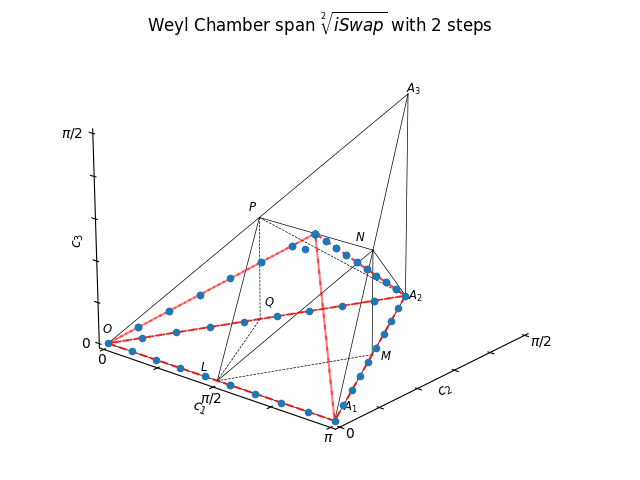

In [33]:
coordinates = weyl_region_plot(gate_params=[1/2], template_range=[2])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', alpha=0.5)

#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
# plt.scatter(*[[mi] for mi in m], color='black', s=100)
plt.show()

[0.49998804 0.49998277 0.49997076]


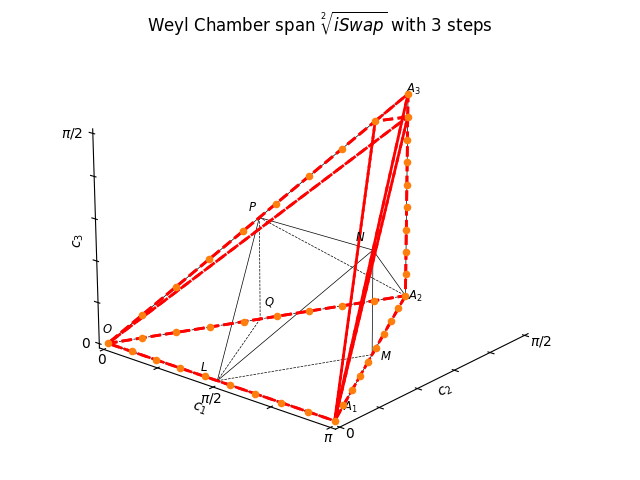

In [9]:
coordinates = weyl_region_plot(gate_params=[1/2], template_range=[3])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

[0.33333333 0.16666668 0.16666665]


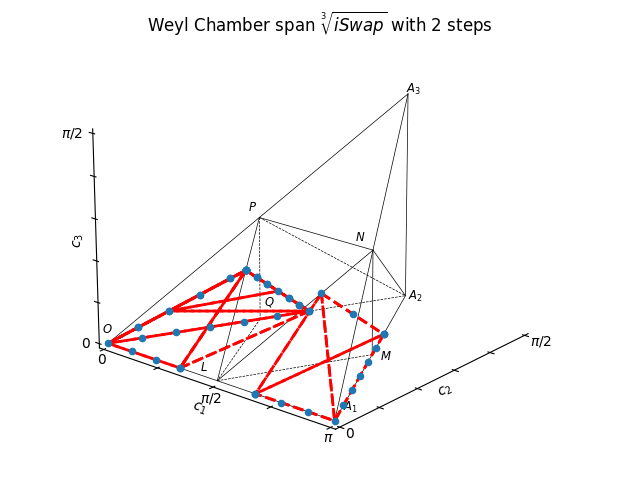

In [31]:
coordinates = weyl_region_plot(gate_params=[1/3], template_range=[2])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

[0.33333447 0.3333331  0.33333242]


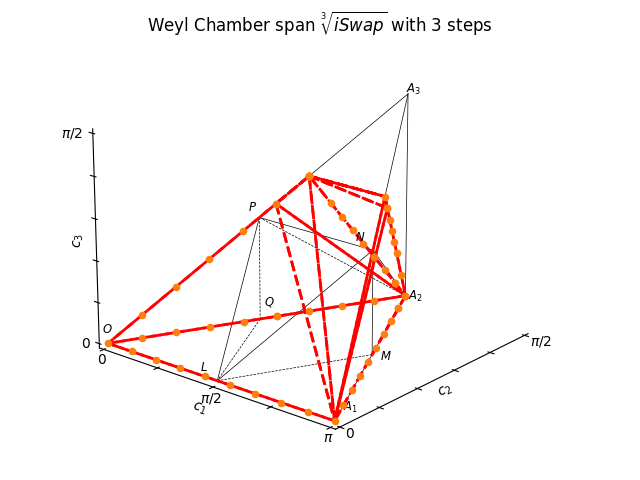

In [11]:
coordinates = weyl_region_plot(gate_params=[1/3], template_range=[3])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

[0.55554817 0.44444328 0.44443822]


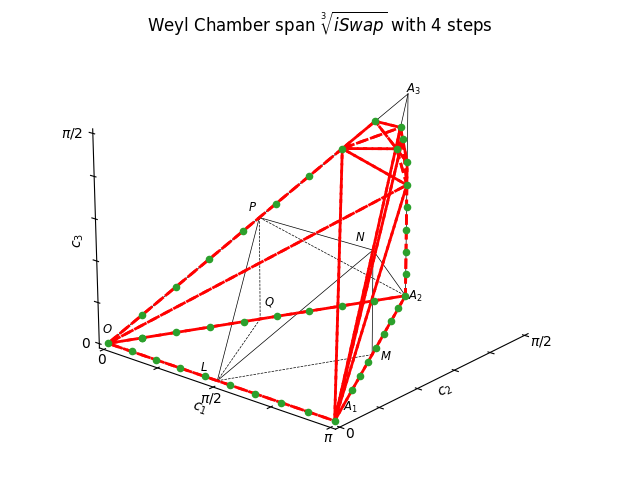

In [12]:
coordinates = weyl_region_plot(gate_params=[1/3], template_range=[4])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

[0.5 0.5 0.5]


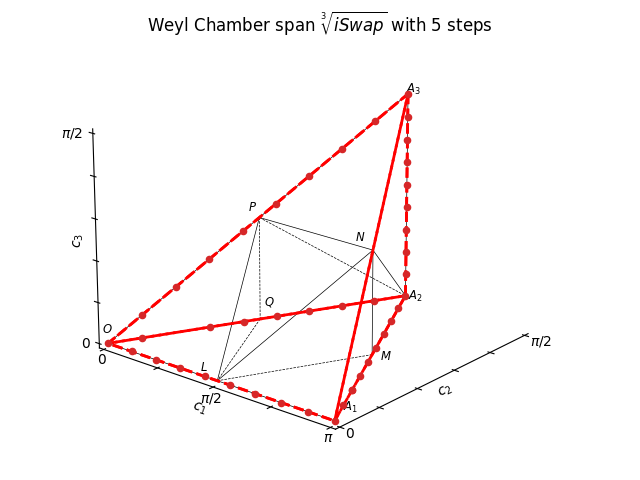

In [13]:
coordinates = weyl_region_plot(gate_params=[1/3], template_range=[5])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

[0.25       0.12500019 0.12499981]


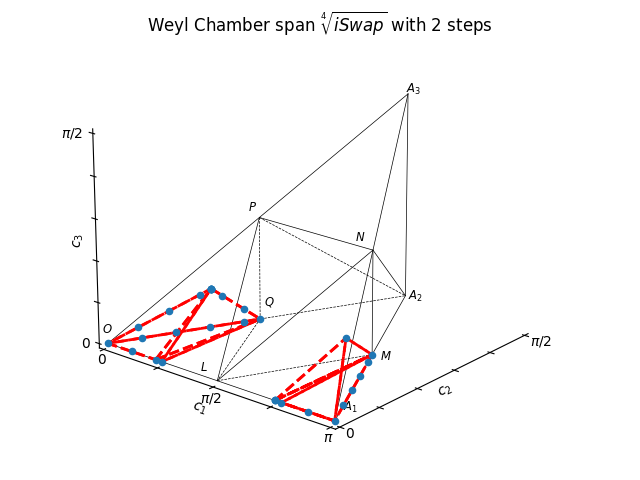

In [34]:
coordinates = weyl_region_plot(gate_params=[1/4], template_range=[2])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

[0.74999912 0.24999973 0.24999939]


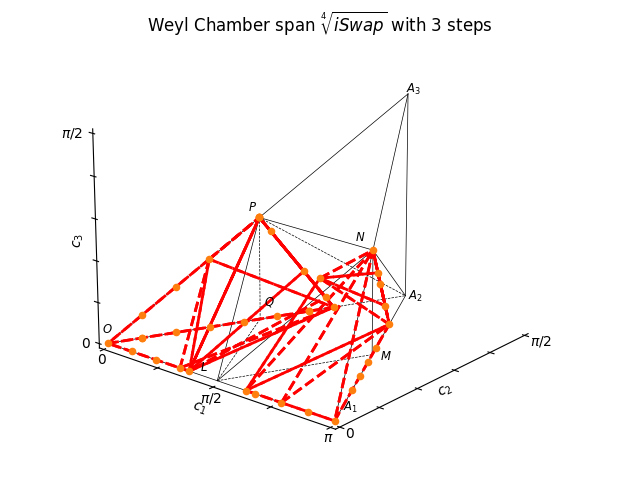

In [35]:
coordinates = weyl_region_plot(gate_params=[1/4], template_range=[3])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

[0.6666633  0.33333219 0.33333111]


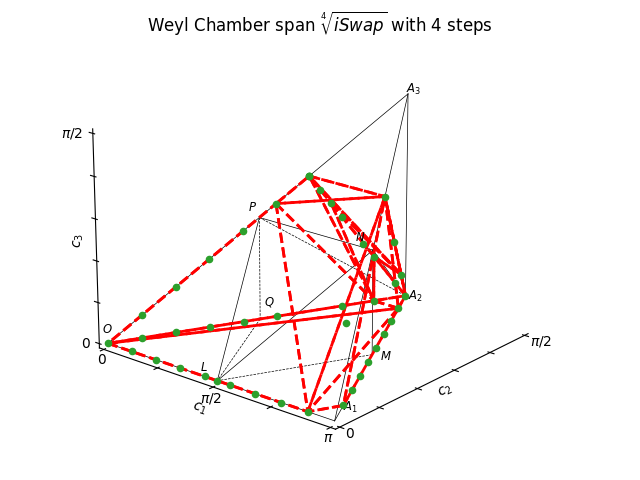

In [16]:
coordinates = weyl_region_plot(gate_params=[1/4], template_range=[4])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

[0.41667696 0.41666408 0.41665885]


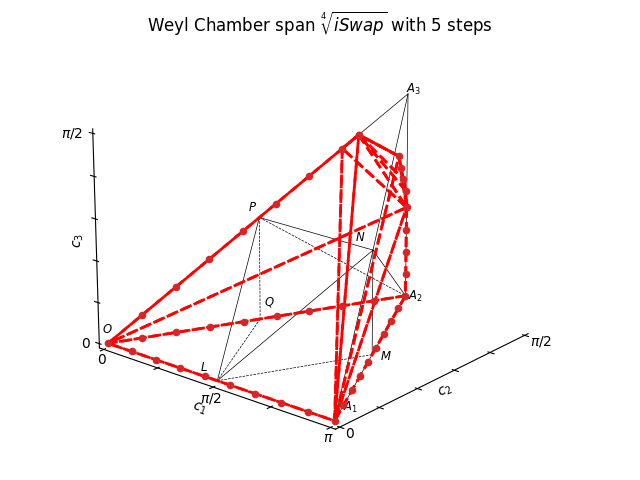

In [17]:
coordinates = weyl_region_plot(gate_params=[1/4], template_range=[5])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

[0.49987211 0.49985942 0.49985675]


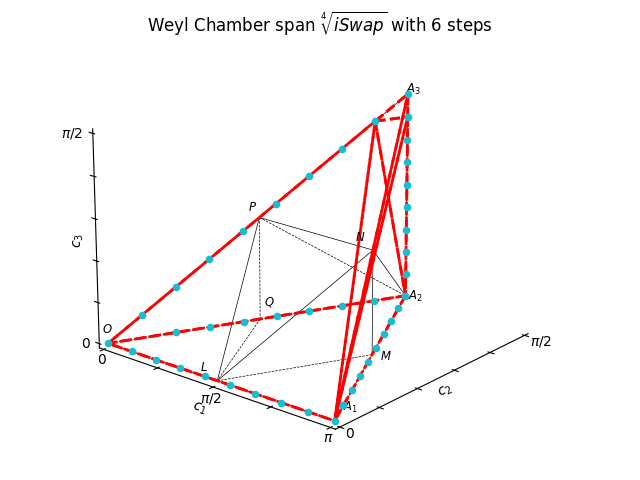

In [18]:
coordinates = weyl_region_plot(gate_params=[1/4], template_range=[6])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

[0.8        0.10000004 0.09999996]


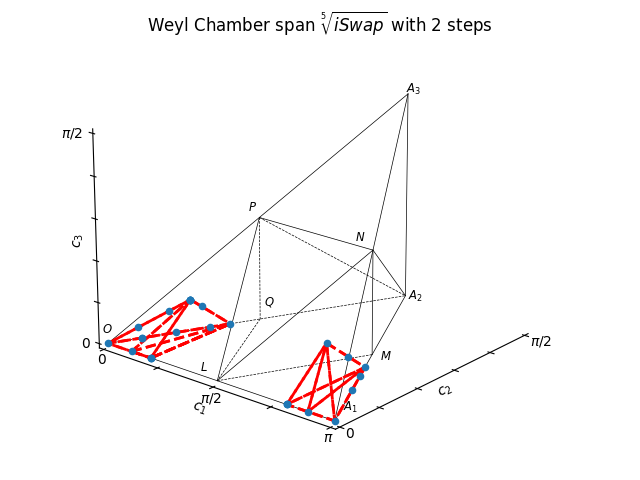

In [36]:
coordinates = weyl_region_plot(gate_params=[1/5], template_range=[2])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

/tmp/ipykernel_1574885/1701714861.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


[0.20000291 0.19999939 0.1999977 ]


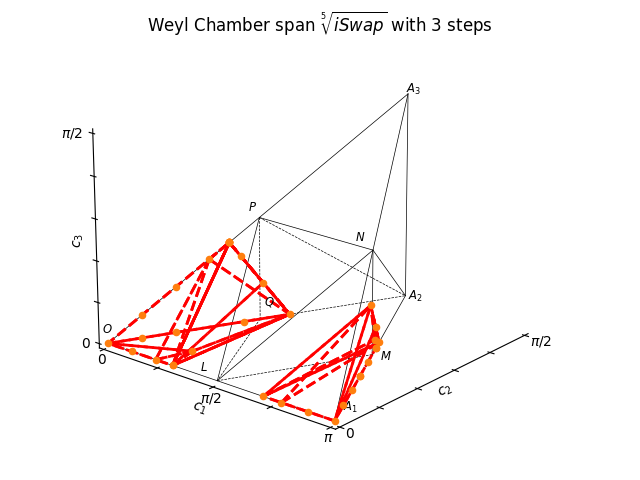

In [37]:
coordinates = weyl_region_plot(gate_params=[1/5], template_range=[3])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

In [38]:
coordinates = weyl_region_plot(gate_params=[1/5], template_range=[6])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

KeyboardInterrupt: 

In [22]:
# coordinates = weyl_region_plot(base_gate=SYC, gate_params=[None], template_range=[2], filename="data/weyl_spanning_syc_2.pkl")
# hull = ConvexHull(coordinates)
# for i in hull.simplices:
#     i = np.append(i, i[0])
#     plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
# plt.show()

In [23]:
# coordinates = weyl_region_plot(base_gate=SYC, gate_params=[None], template_range=[3], filename="data/weyl_spanning_syc_3.pkl")
# hull = ConvexHull(coordinates)
# for i in hull.simplices:
#     i = np.append(i, i[0])
#     plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
# plt.show()

In [24]:
# coordinates = weyl_region_plot(base_gate=SYC, gate_params=[None], template_range=[4], filename="data/weyl_spanning_syc_4.pkl")
# hull = ConvexHull(coordinates)
# for i in hull.simplices:
#     i = np.append(i, i[0])
#     plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
# plt.show()

In [25]:
#TODO coordinates => analytically defined polyehdra
# use convex hull to find vertexes
# use vertexes to define planes



In [26]:
# #TODO plot haar gate distribution in weyl chamber
# from qiskit.quantum_info.random import random_unitary, random_clifford
# from qiskit.quantum_info import Operator
# from weylchamber import c1c2c3, WeylChamber
# w = WeylChamber()
# for _ in range(1000):
#     #coord = c1c2c3(Operator(random_unitary(dims=4)).data)
#     coord = c1c2c3(Operator(random_clifford(num_qubits=2)).data)
#     w.add_point(*coord)

# w.plot()

In [27]:
# # from weylchamber import c1c2c3 as weyl_coordinates
# from qiskit.quantum_info.synthesis.weyl import weyl_coordinates
# def trace_to_fid(trace):
#     """Average gate fidelity is :math:`Fbar = (d + |Tr (Utarget \\cdot U^dag)|^2) / d(d+1)`
#     M. Horodecki, P. Horodecki and R. Horodecki, PRA 60, 1888 (1999)"""
#     return (4 + abs(trace) ** 2) / 2

# def num_basis_gates(unitary):
#     """Computes the number of basis gates needed in
#     a decomposition of input unitary
#     """
#     from qiskit.quantum_info.synthesis import TwoQubitBasisDecomposer
#     basis = TwoQubitBasisDecomposer(RiSwapGate).basis

#     unitary = np.asarray(unitary, dtype=complex)
#     a, b, c = weyl_coordinates(unitary)[:]
    
#     # Future gotcha: extending this to non-supercontrolled basis.
#     # Careful: closest distance between a1,b1,c1 and a2,b2,c2 may be between reflections.
#     # This doesn't come up if either c1==0 or c2==0 but otherwise be careful.
#     """:math:`|Tr(U \\cdot Utarget^dag)|`"""
#     traces = [
#         4
#         * (
#             np.cos(a) * np.cos(b) * np.cos(c)
#             + 1j * np.sin(a) * np.sin(b) * np.sin(c)
#         ),
#         4
#         * (
#             np.cos(np.pi / 4 - a) * np.cos(basis.b - b) * np.cos(c)
#             + 1j * np.sin(np.pi / 4 - a) * np.sin(basis.b - b) * np.sin(c)
#         ),
#         4 * np.cos(c),
#         4,
#     ]
#     basis_fidelity=1.0
#     return np.argmax([trace_to_fid(traces[i]) * basis_fidelity**i for i in range(4)])

# from qiskit.circuit.library.standard_gates import *
# num_basis_gates(SwapGate())